In [1]:
import math
import random

In [2]:
# utility function for topoligical sort

In [3]:
def build_topo(root):
    def build_topo_recursive(v):
        if v is None:
            return
        if v not in visited:
            visited.add(v)
            if v.prev:
                for child in set(v.prev):
                    build_topo_recursive(child)
            topo.append(v)

    visited = set()
    topo = []
    build_topo_recursive(root)
    return topo

In [4]:
# define Value, which is like torch.tensor

In [5]:
class Value:
    def __init__(self, data, op=None, prev=None):
        self.data = data
        self.grad = 0.0
        self.op = op
        self.prev = prev
        
    def __repr__(self):
        # return f"Value({self.data, self.grad, self.op, self.prev})"
        return f"Value(data={self.data:.6f}, grad={self.grad:.6f})"
        
    # ---------------------------------------------------
    # operators
    # ---------------------------------------------------
    def __add__(self, y):
        return Value(self.data + y.data, op='+', prev=(self, y))

    def __sub__(self, y):
        return Value(self.data - y.data, op='-', prev=(self, y))

    def __mul__(self, y):
        return Value(self.data * y.data, op='*', prev=(self, y))
    
    def tanh(self):
        return Value(math.tanh(self.data), op='tanh', prev=(self,))

    @staticmethod
    def populate_gradients(out, op, prev):
        if prev is None:
            return
        match op:
            case '+':
                x, y = prev
                x.grad += out.grad
                y.grad += out.grad
            case '-':
                x, y = prev
                x.grad += out.grad
                y.grad -= out.grad
            case '*':
                x, y = prev
                x.grad += y.data * out.grad
                y.grad += x.data * out.grad
            case 'tanh':
                (x,) = prev
                x.grad += (1 - out.data**2) * out.grad
            case _:
                assert False, f'unsupported op: {op}'
    # ---------------------------------------------------
    # backward
    # ---------------------------------------------------
    def backward(self):
        topo = build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            Value.populate_gradients(node, node.op, node.prev)

In [6]:
u = Value(2)
u

Value(data=2.000000, grad=0.000000)

In [7]:
v = Value(3.0)
v

Value(data=3.000000, grad=0.000000)

In [8]:
w = Value(5.1)
w

Value(data=5.100000, grad=0.000000)

In [9]:
# case 1

In [10]:
L = u.tanh()
L

Value(data=0.964028, grad=0.000000)

In [11]:
L.grad = 1.0
L

Value(data=0.964028, grad=1.000000)

In [12]:
L.prev

(Value(data=2.000000, grad=0.000000),)

In [13]:
u.grad = 0

In [14]:
L.backward()

In [15]:
u

Value(data=2.000000, grad=0.070651)

In [16]:
# case 2

In [17]:
L = u - v
# L = v - u

In [18]:
u.grad = 0
v.grad = 0

In [19]:
L.backward()

In [20]:
L

Value(data=-1.000000, grad=1.000000)

In [21]:
u, v

(Value(data=2.000000, grad=1.000000), Value(data=3.000000, grad=-1.000000))

In [22]:
# case 3

In [23]:
L = u + u

In [24]:
u.grad = 0
v.grad = 0

In [25]:
L.backward()

In [26]:
L

Value(data=4.000000, grad=1.000000)

In [27]:
u, v

(Value(data=2.000000, grad=2.000000), Value(data=3.000000, grad=0.000000))

In [28]:
# case 4

In [29]:
L = u + v
L

Value(data=5.000000, grad=0.000000)

In [30]:
u.grad = 0
v.grad = 0

In [31]:
L

Value(data=5.000000, grad=0.000000)

In [32]:
tp = build_topo(L)
tp

[Value(data=3.000000, grad=0.000000),
 Value(data=2.000000, grad=0.000000),
 Value(data=5.000000, grad=0.000000)]

In [33]:
len(tp)

3

In [34]:
L.backward()

In [35]:
L

Value(data=5.000000, grad=1.000000)

In [36]:
L

Value(data=5.000000, grad=1.000000)

In [37]:
v

Value(data=3.000000, grad=1.000000)

In [38]:
u

Value(data=2.000000, grad=1.000000)

In [39]:
# case 5

In [40]:
w = Value(5.1)
w

Value(data=5.100000, grad=0.000000)

In [41]:
L = u * v + w
L

Value(data=11.100000, grad=0.000000)

In [42]:
u.grad = 0
v.grad = 0
w.grad = 0

In [43]:
L.backward()

In [44]:
u, v, w

(Value(data=2.000000, grad=3.000000),
 Value(data=3.000000, grad=2.000000),
 Value(data=5.100000, grad=1.000000))

In [45]:
# define nn, which is like torch.nn

In [46]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        # self.b = Value(0)
        
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons] 
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [para for neuron in self.neurons for para in neuron.parameters()]
    

class MLP:
    def __init__(self, nin, nouts):
        dims = [nin] + nouts
        self.layers = [Layer(dim_in, dim_out) for dim_in, dim_out in zip(dims, dims[1:])]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [para for layer in self.layers for para in layer.parameters()]

In [47]:
x1 = [
  [Value(2.0), Value(3.0), Value(-1.0)],
  [Value(3.0), Value(-1.0), Value(0.5)],
  [Value(0.5), Value(1.0), Value(1.0)],
  [Value(1.0), Value(1.0), Value(-1.0)],
]
x2 = [
    [Value(1.0), Value(2.0)], 
    [Value(3.0), Value(4.0)],
    [Value(0.5), Value(-2.1)],
    [Value(1.3), Value(1.5)],
]     
y = [Value(1.0), Value(-1.0), Value(-1.0), Value(1.0)]

In [48]:
# nn = MLP(3, [4, 4, 1])
nn = MLP(2, [4, 4, 1])

In [49]:
from tqdm import tqdm

In [50]:
ll = []
loss = []
for i in tqdm(range(2000)):
    # forward
    ypred = [nn(xi) for xi in x2]
    L = sum(((yout - ygt)*(yout - ygt) for yout, ygt in zip(ypred, y)), Value(0))

    # backward
    for p in nn.parameters():
        p.grad = 0.0
    L.backward()

    # update
    for p in nn.parameters():
        p.data += -0.01 * p.grad
        
    # print(i, L)
    ll.append(math.log(L.data))
    loss.append(L.data)

100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1606.29it/s]


In [51]:
import matplotlib.pyplot as plt

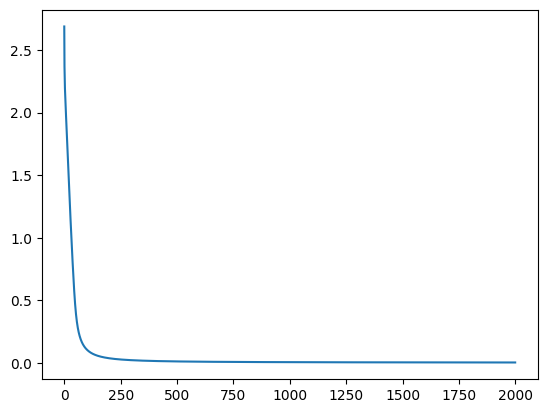

In [52]:
plt.plot(loss)

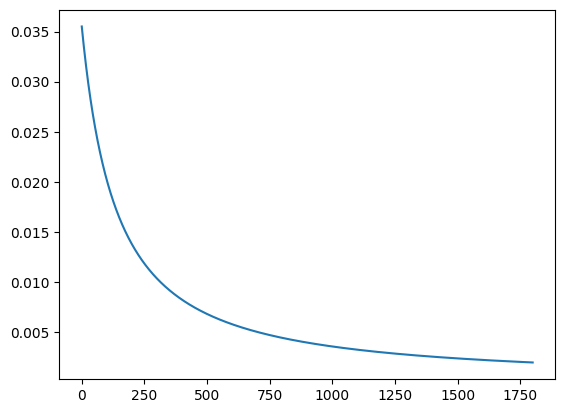

In [53]:
plt.plot(loss[200:])

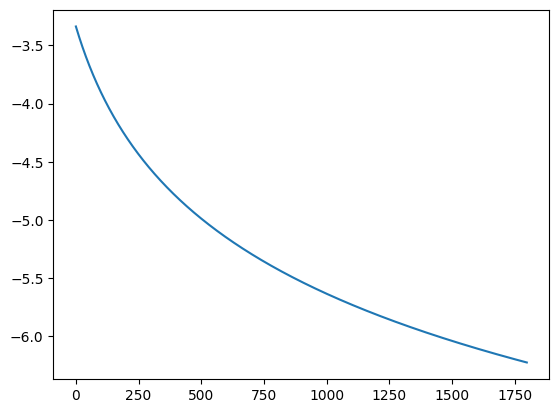

In [54]:
plt.plot(ll[200:])

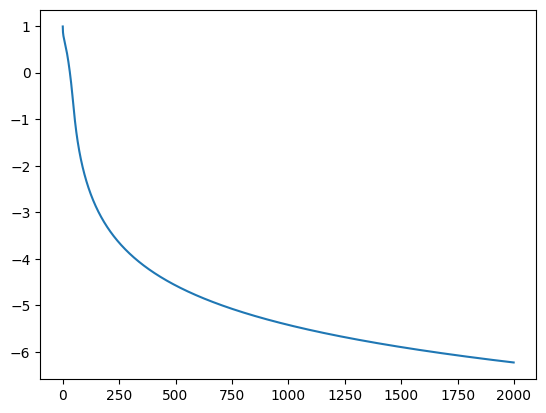

In [55]:
plt.plot(ll)

In [56]:
L

Value(data=0.001979, grad=1.000000)

In [57]:
ll[:5]

[0.9893389361782109,
 0.8625137553180984,
 0.8132786493856355,
 0.7852465817328455,
 0.7622812092779981]

In [58]:
ll[-5:]

[-6.222759703645376,
 -6.223332208867843,
 -6.223904413654192,
 -6.2244763183162375,
 -6.225047923165302]

In [59]:
ypred

[Value(data=0.979850, grad=-0.040299),
 Value(data=-0.974504, grad=0.050993),
 Value(data=-0.977654, grad=0.044691),
 Value(data=0.979413, grad=-0.041174)]